In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
cd gdrive/My Drive

In [3]:
import numpy as np 
import cv2
import os
import skimage.io as io
import skimage.transform as trans
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
import tensorflow as tf
import matplotlib.pyplot as plt
# tensorflow and inputs and outputs

def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model


def load_img(filename):
  _, data_set	=	cv2.imreadmulti(filename)
  data_set = np.array(data_set)
  #transform 3d to 4d
  data_set = data_set[:,:,:,np.newaxis]
  #change 255 to 1 for all the pixel so that all the values are 0 or 1
  data_set = data_set/255
  return data_set

In [4]:
# Dataset-> https://www.epfl.ch/labs/cvlab/data/data-em/
x_train = load_img('training.tif')
y_train = load_img('training_groundtruth.tif')
x_valid = load_img('testing.tif')
y_valid = load_img('testing_groundtruth.tif')
#y_train[np.where(y_train == 255)] = 1
#y_valid[np.where(y_valid == 255)] = 1

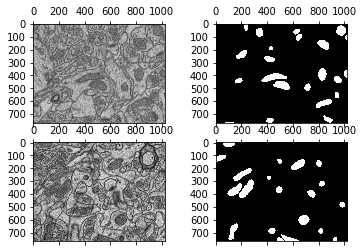

In [5]:
fig = plt.figure()
ax = fig.add_subplot(2,2,1)
ax.matshow(x_train[0,:,:,0],cmap = plt.cm.gray,vmin=0, vmax=1)
ax = fig.add_subplot(2,2,2)
ax.matshow(y_train[0,:,:,0],cmap = plt.cm.gray)
ax = fig.add_subplot(2,2,3)
ax.matshow(x_valid[0,:,:,0],cmap = plt.cm.gray)
ax = fig.add_subplot(2,2,4)
ax.matshow(y_valid[0,:,:,0],cmap = plt.cm.gray)
plt.show()

In [6]:
model = unet(input_size = (768, 1024, 1))

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 768, 1024, 1 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 768, 1024, 64 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 768, 1024, 64 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 384, 512, 64) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [7]:
history = model.fit(x_train, y_train, epochs=5, batch_size=2, validation_data=(x_valid, y_valid))

Epoch 1/5
83/83 [==============================] - 176s 2s/step - loss: 0.1895 - accuracy: 0.9348 - val_loss: 0.1461 - val_accuracy: 0.9469
Epoch 2/5
83/83 [==============================] - 176s 2s/step - loss: 0.0872 - accuracy: 0.9643 - val_loss: 0.1338 - val_accuracy: 0.9577
Epoch 3/5
83/83 [==============================] - 177s 2s/step - loss: 0.0455 - accuracy: 0.9812 - val_loss: 0.1479 - val_accuracy: 0.9696
Epoch 4/5
83/83 [==============================] - 178s 2s/step - loss: 0.0297 - accuracy: 0.9879 - val_loss: 0.1244 - val_accuracy: 0.9755
Epoch 5/5
83/83 [==============================] - 178s 2s/step - loss: 0.0214 - accuracy: 0.9914 - val_loss: 0.1507 - val_accuracy: 0.9758


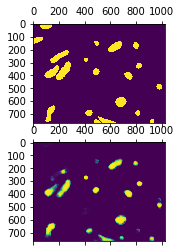

In [8]:
y_hat = model.predict(np.array([x_valid[0]]))
#y_hat[np.where(y_hat < 0.5)] = 0
#y_hat[np.where(y_hat >= 0.5)] = 1
fig = plt.figure()
ax = fig.add_subplot(2,1,1)
ax.matshow(y_valid[0,:,:,0])
ax = fig.add_subplot(2,1,2)
ax.matshow(y_hat[0,:,:,0])
plt.show()